In [185]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
import tensorflow.keras.losses
import tensorflow.keras.metrics
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [18]:
%matplotlib notebook
K.set_image_data_format('channels_last')
                    #initiate the variables
smooth=1.0
img_rows = 96
img_cols = 96

In [ ]:
def load_images(num_img): #import all the images
    num_test=400
    Dossier_Complet= os.listdir('./train/')
    Dossier_Complet= [re.split('_|\.', i) for i in Dossier_Complet]

    original=sorted([i[:2] for i in Dossier_Complet[:num_img] if len(i)==3])
    original=['_'.join(i) for i in original]

    #set_train = [imread('./train/'+str(i)+'.tif') for i in original[:]]
    #set_mask = [imread('./train/'+str(i)+'_mask.tif') for i in original[:]]
    
    set_train = [imread('./train/'+str(i)+'.tif') for i in original[num_test:]]
    set_mask = [imread('./train/'+str(i)+'_mask.tif') for i in original[num_test:]]
    set_test = [imread('./train/'+str(i)+'.tif') for i in original[:num_test]]
    set_test_mask = [imread('./train/'+str(i)+'_mask.tif') for i in original[:num_test]]
    return set_train, set_mask, set_test, set_test_mask

def preprocessing(imgs, rows, cols, normalized=False, mask=False): #preprocessing to add one channels and to normalize
    img_1 = np.ndarray((np.asarray(imgs).shape[0],rows, cols), dtype=np.uint8)
    img_1 = np.asarray([resize(i, (rows, cols, 1), preserve_range=True) for i in imgs])
    #img_1 = img_1[..., np.newaxis]
    
    if normalized:
        img_1= (img_1/255.)#-0.5
    if mask:
        #img_1 = np.asarray([resize(i, (rows, cols, 2), preserve_range=True) for i in imgs])
        #img_1[img_1<150] = 0
        #img_1[img_1>=150] = 1  
        img_1/=255.
        
    return img_1

In [175]:
def dice_coef(y_true, y_pred): #to evaluate the model
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true)+K.sum(y_pred)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

In [191]:
def dice_coef1(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 1
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred): #to make the average with the dice coef of the 2 classes (sofmax)
    dice=0
    for index in range(2):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/2 # taking average

In [114]:
#set_train, set_mask = load_images(20401)

set_train, set_mask, set_test, set_test_mask  = load_images(20000)

img_train= preprocessing(set_train, img_rows, img_cols, normalized=True)
img_mask= preprocessing(set_mask, img_rows, img_cols, mask=True)

test_set= preprocessing(set_test, img_rows, img_cols, normalized=True)
test_mask_set= preprocessing(set_test_mask, img_rows, img_cols, mask=True)

In [220]:
img_ROI1=[]
mask_ROI1=[]
img_ROI_test=[]
mask_ROI_test=[]

for i in range(len(img_mask)): #to take only the image with a region of interest (nerve)
    if img_mask[i].sum()!=0:
        mask_ROI1.append(img_mask[i])
        img_ROI1.append(img_train[i])
        
for i in range(len(test_mask_set)):
    if test_mask_set[i].sum()!=0:
        mask_ROI_test.append(test_mask_set[i])
        img_ROI_test.append(test_set[i])

In [120]:
print(np.asarray(img_ROI1).shape)
print(np.asarray(mask_ROI1).shape)

(2141, 96, 96, 1)
(2141, 96, 96, 1)


In [110]:
def mask2channels(imgs): #to give 2 channels for the mask and use the softmax
    img_1 = np.ndarray((np.asarray(imgs).shape[0],np.asarray(imgs).shape[1], np.asarray(imgs).shape[2], 2), dtype=np.float)
    #img_1[:,:,:,0]= [i[:,:,0] for i in imgs]
    img_1[:,:,:,1]= [1-i[:,:,0] for i in imgs]
    img_1[:,:,:,0]= 1-img_1[:,:,:,1]
    return img_1

In [221]:
mask_ROI_F= mask2channels(mask_ROI1)
test_mask_ROI_F= mask2channels(mask_ROI_test)

In [144]:
img_maskf = mask2channels(img_mask)

<IPython.core.display.Javascript object>


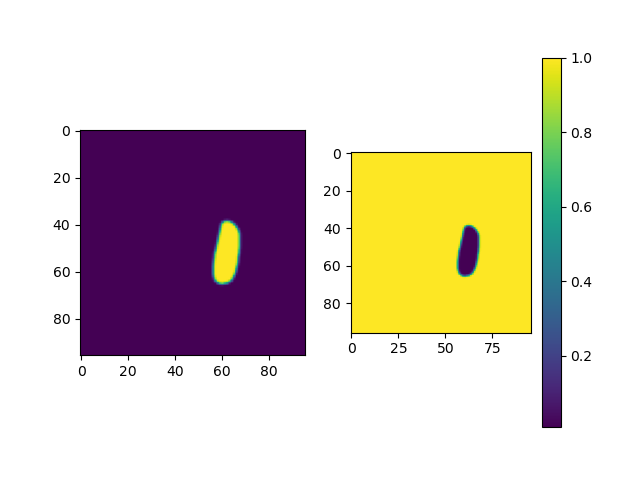

In [170]:
n=89
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_mask[n,:,:,0])
plt.subplot(1,2,2)
plt.imshow(img_maskf[n,:,:,1])
plt.colorbar()
plt.show()

In [121]:
print(np.asarray(mask_ROI_F).shape)

(2141, 96, 96, 2)


<IPython.core.display.Javascript object>


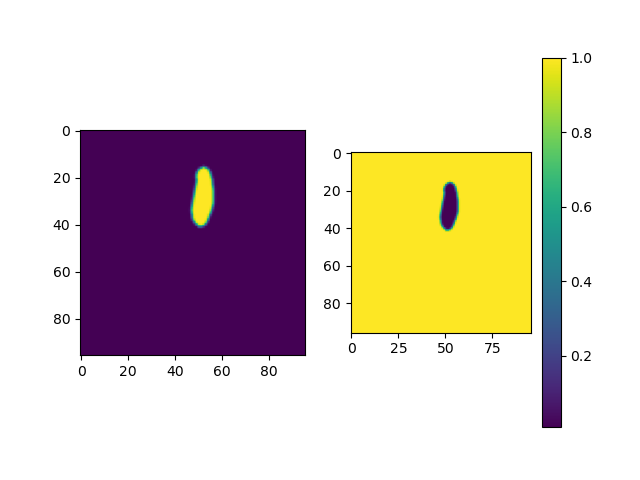

In [163]:
n=540
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask_ROI_F[n,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask_ROI_F[n,:,:,1])
plt.colorbar()
plt.show()

(96, 96, 1)


<IPython.core.display.Javascript object>


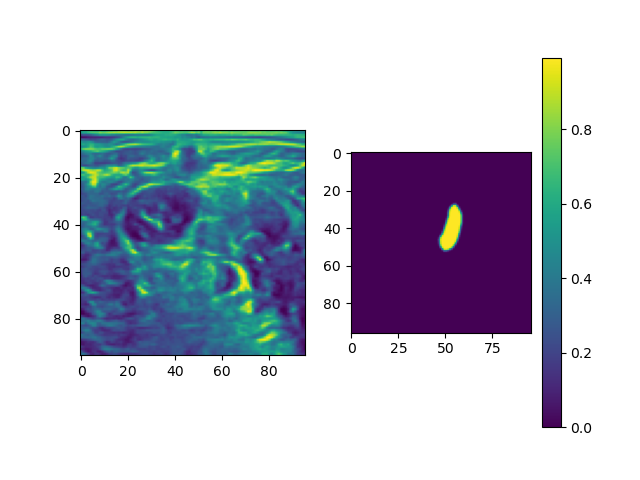

In [26]:
print(img_ROI[73].shape)
n=67
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ROI[n])
plt.subplot(1,2,2)
plt.imshow(mask_ROI[n])
plt.colorbar()
plt.show()

In [207]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    #Drop1 = Dropout(0.5)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    #Drop1 = Dropout(0.5)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    #Drop1 = Dropout(0.5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    #Drop1 = Dropout(0.5)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    
    #Drop1 = Dropout(0.5)
    

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    #conv10 = Conv2D(1, (1, 1), activation='relu')(conv9)
    
    conv10 = Conv2D(2, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer= Adam(lr=1e-3), loss= [tensorflow.keras.losses.binary_crossentropy], metrics=[dice_coef_multilabel])

    return model

model = get_unet()

model_Early= EarlyStopping(monitor="val_dice_coef_multilabel", patience=10, verbose=2, mode="max")

model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_dice_coef_multilabel', mode="max", save_best_only=True)


#history = model.fit(img_train, img_maskf, batch_size=32, epochs=5,  verbose=1, shuffle=True,
#            validation_split=0.2, callbacks=[model_checkpoint, model_Early])

history = model.fit(np.asarray(img_ROI1), mask_ROI_F, batch_size=32, epochs=20,  verbose=1, shuffle=True,
              validation_split=0.2, callbacks=[model_checkpoint, model_Early])

Train on 1712 samples, validate on 429 samples
Epoch 1/20
1712/1712 [==============================] - 33s 19ms/step - loss: 6.9147 - dice_coef_multilabel: 0.4849 - val_loss: 2.9537 - val_dice_coef_multilabel: 0.5471
Epoch 2/20
1712/1712 [==============================] - 4s 2ms/step - loss: 2.6987 - dice_coef_multilabel: 0.5770 - val_loss: 2.3549 - val_dice_coef_multilabel: 0.6009
Epoch 3/20
1712/1712 [==============================] - 4s 2ms/step - loss: 2.1303 - dice_coef_multilabel: 0.6380 - val_loss: 1.9566 - val_dice_coef_multilabel: 0.6900
Epoch 4/20
1712/1712 [==============================] - 4s 2ms/step - loss: 1.6283 - dice_coef_multilabel: 0.7306 - val_loss: 1.7827 - val_dice_coef_multilabel: 0.7672
Epoch 5/20
1712/1712 [==============================] - 4s 2ms/step - loss: 1.3607 - dice_coef_multilabel: 0.7768 - val_loss: 1.5171 - val_dice_coef_multilabel: 0.7726
Epoch 6/20
1712/1712 [==============================] - 4s 2ms/step - loss: 1.1999 - dice_coef_multilabel: 0.80

<IPython.core.display.Javascript object>


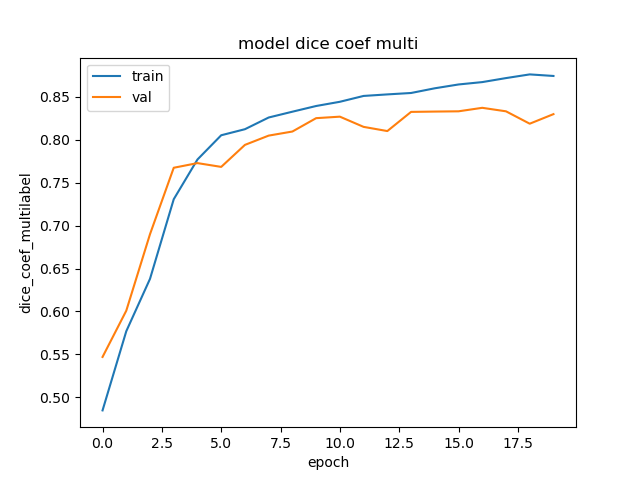

<IPython.core.display.Javascript object>


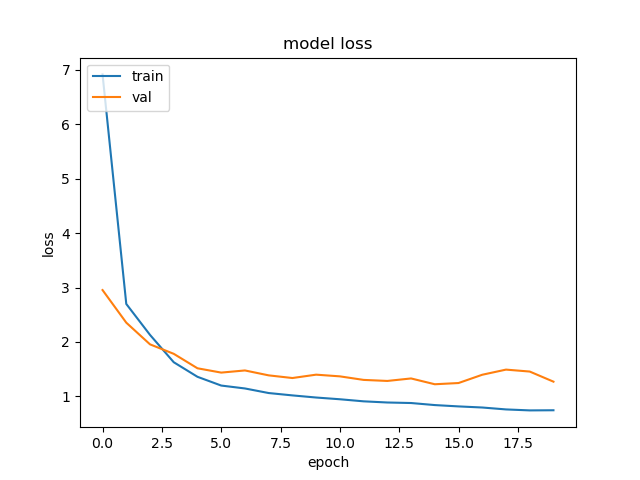

In [208]:
#list all data in history
#print(history.history)
#summarize history for accuracy
plt.figure()
plt.plot(history.history["dice_coef_multilabel"])
plt.plot(history.history["val_dice_coef_multilabel"])
plt.title('model dice coef multi')
plt.ylabel("dice_coef_multilabel")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()
#summarize history for loss
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 96, 96, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 96, 96, 32)   9248        conv2d_151[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 48, 48, 32)   0           conv2d_152[0][0]                 
__________________________________________________________________________________________________
conv2d_153

In [147]:
predict = model.predict(img_train[801:])

<IPython.core.display.Javascript object>


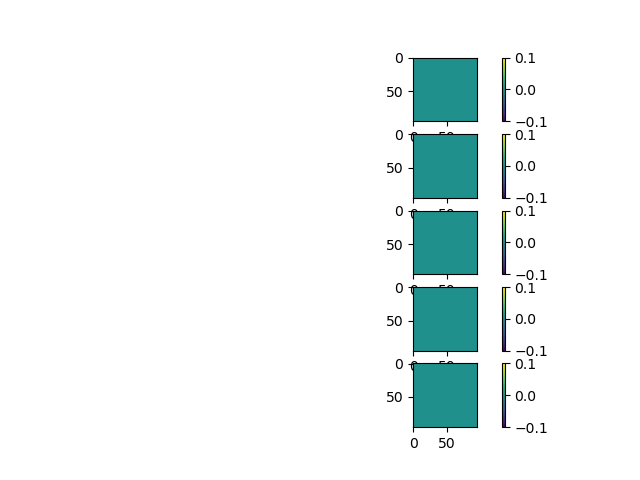

In [158]:
num=93
#result= predict[num][:,:,0]
#predict[predict>=0.7]=1
#predict[predict<0.7]=0  1   802

plt.figure()  
plt.subplot(1,2,1)
plt.imshow(img_train[num+801])
plt.subplot(1,2,2)
plt.imshow(img_maskf[num+801,:,:,0])
plt.subplot(1,3,3)
plt.colorbar()
plt.show()

In [161]:
g=0
for i in predict[:,:,:,0]:
    if np.asarray(i).sum()!=0:
        g+=1
print(g)

0


In [193]:
predict = model.predict(np.asarray(img_ROI1[801:]))

<IPython.core.display.Javascript object>


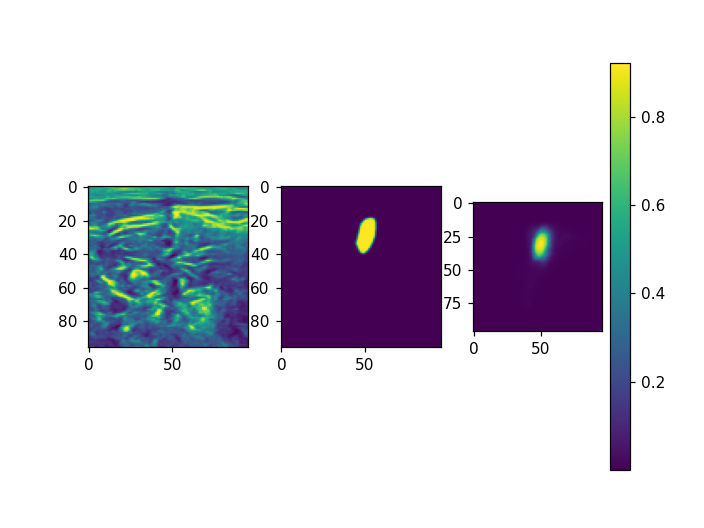

In [195]:
num=76
#result= predict[num][:,:,0]
#predict[predict>=0.7]=1
#predict[predict<0.7]=0  1   802

plt.figure()  
plt.subplot(1,3,1)
plt.imshow(img_ROI1[num+801])
plt.subplot(1,3,2)
plt.imshow(mask_ROI_F[num+801,:,:,0])
plt.subplot(1,3,3)
plt.imshow(predict[num,:,:,0])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


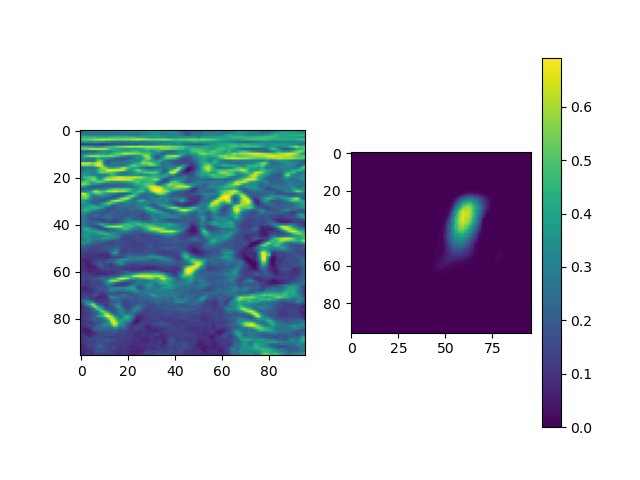

In [65]:
num=69
#result= predict[num][:,:,0]
#predict[predict>=0.7]=1
#predict[predict<0.7]=0  1   802

plt.figure()  
plt.subplot(1,2,1)
plt.imshow(img_train[num+801])
plt.subplot(1,2,2)
plt.imshow(predict[num])
plt.colorbar()
plt.show()

In [222]:
model.evaluate(np.asarray(img_ROI_test), test_mask_ROI_F)

182/182 [==============================] - 0s 1ms/step


[1.4294807052874303, 0.7967390031604976]

In [211]:
model.save("modelok")

In [215]:
modelok = keras.models.load_model("modelok", custom_objects=dice_coef_multilabel)

TypeError: argument of type 'function' is not iterable

In [223]:
predict=model.predict(np.asarray(img_ROI_test))

<IPython.core.display.Javascript object>


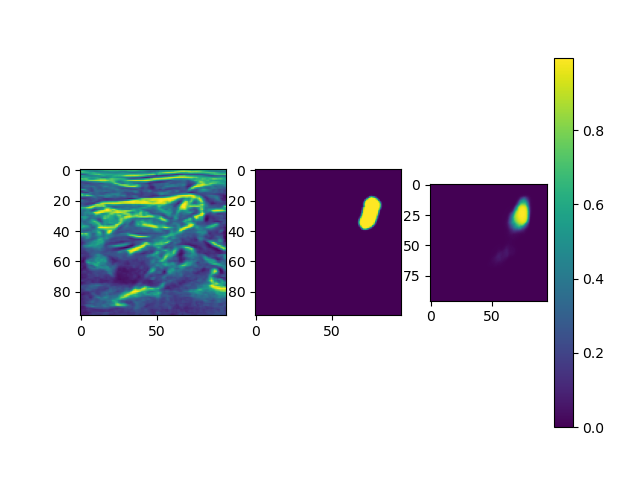

In [233]:
num=30

plt.figure()  
plt.subplot(1,3,1)
plt.imshow(img_ROI_test[num])
plt.subplot(1,3,2)
plt.imshow(test_mask_ROI_F[num,:,:,0])
plt.subplot(1,3,3)
plt.imshow(predict[num,:,:,0])
plt.colorbar()
plt.show()